In [1]:
import numpy as np

import jax
import jax.numpy as jnp

import crayopt

import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(889999)

CUDA backend failed to initialize: Found cuBLAS version 120205, but JAX was built against version 120304, which is newer. The copy of cuBLAS that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def broadcast_left(x, ndim):
  broadcast = tuple(slice(None, None, None) for _ in range(x.ndim)) + \
              tuple(None for _ in range(ndim - x.ndim))

  return x[broadcast]

def log_prob_transition(random_walk, sigmas) -> jnp.ndarray:
  """
  Returns unnormalized log probabilities for a random walk instance `random_walk` generated with step size `alpha`.
  :param random_walk: an instance of random walk as returned by `langevin_step`;
  :param sigmas: std of the `random_walk`.
  :return: unnormalized log probabilities.
  """
  from .. import utils

  return utils.tree.tree_map_sum(
    lambda eps, sigma: -jnp.sum(
      0.5 * jnp.square(eps / broadcast_left(sigma, eps.ndim)) + jnp.log(broadcast_left(sigma, eps.ndim)),
      axis=tuple(range(1, eps.ndim))
    ),
    random_walk, sigmas
  )

In [44]:
@jax.jit
def log_p(x):
    return -(
        jnp.square(1 - x[..., 0]) + 100 * jnp.square(x[..., 1] - jnp.square(x[..., 0]))
    )

@jax.jit
def norm_grad_log_p(x):
    grad = jax.vmap(
        jax.grad(log_p, argnums=0), in_axes=0, out_axes=0
    )(x)
    return jnp.sqrt(jnp.sum(jnp.sqrt(grad), axis=1))

def mh(key, learning_rate, x):
    key_noise, key_u, = jax.random.split(key, num=2)

    eps = learning_rate * jax.random.normal(key, shape=x.shape, dtype=x.dtype)
    proposal = x + eps

    log_p_x = log_p(x)
    log_p_proposal = log_p(proposal)

    ### due to symmetry of the proposal distribution transition probs cancel out
    transition_log_prob = log_p_proposal - log_p_x

    log_u = jnp.log(
      jax.random.uniform(key_u, shape=transition_log_prob.shape, dtype=transition_log_prob.dtype) + 1.0e-6
    )

    accepted = log_u < transition_log_prob

    updated = jnp.where(
        jnp.expand_dims(accepted, axis=range(1, len(x.shape))),
        proposal, x
      )

    return updated

def naive(key, learning_rate, x):
    key_noise, key_u, = jax.random.split(key, num=2)

    lr = learning_rate * norm_grad_log_p(x)
    
    eps = lr[:, None] * jax.random.normal(key, shape=x.shape, dtype=x.dtype)
    proposal = x + eps

    lr_proposal = learning_rate * norm_grad_log_p(proposal)

    log_p_x = log_p(x)
    log_p_proposal = log_p(proposal)

    log_p_x_proposal = jnp.sum(-0.5 * jnp.square(eps / lr[:, None]) - jnp.log(lr[:, None]), axis=1)
    log_p_proposal_x = jnp.sum(-0.5 * jnp.square(eps / lr_proposal[:, None]) - jnp.log(lr_proposal[:, None]), axis=1)

    ### due to symmetry of the proposal distribution transition probs cancel out
    transition_log_prob = log_p_proposal - log_p_x + log_p_proposal_x - log_p_x_proposal

    log_u = jnp.log(
      jax.random.uniform(key_u, shape=transition_log_prob.shape, dtype=transition_log_prob.dtype) + 1.0e-6
    )

    accepted = log_u < transition_log_prob

    updated = jnp.where(
        jnp.expand_dims(accepted, axis=range(1, len(x.shape))),
        proposal, x
      )

    return updated

def adamh(key, learning_rate, x):
    key_noise, key_u, = jax.random.split(key, num=2)

    lr = learning_rate * norm_grad_log_p(x)
    
    eps = lr[:, None] * jax.random.normal(key, shape=x.shape, dtype=x.dtype)
    proposal = x + eps

    lr_proposal = learning_rate * norm_grad_log_p(proposal)

    log_p_x = log_p(x)
    log_p_proposal = log_p(proposal)

    log_p_x_proposal = jnp.sum(-0.5 * jnp.square(eps / lr[:, None]) - jnp.log(lr[:, None]), axis=1)
    log_p_proposal_x = jnp.sum(-0.5 * jnp.square(eps / lr_proposal[:, None]) - jnp.log(lr_proposal[:, None]), axis=1)

    ### due to symmetry of the proposal distribution transition probs cancel out
    transition_log_prob = log_p_proposal - log_p_x + log_p_proposal_x - log_p_x_proposal

    log_u = jnp.log(
      jax.random.uniform(key_u, shape=transition_log_prob.shape, dtype=transition_log_prob.dtype) + 1.0e-6
    )

    accepted = log_u < transition_log_prob

    updated = jnp.where(
        jnp.expand_dims(accepted, axis=range(1, len(x.shape))),
        proposal, x
      )

    return lr, updated

@jax.jit
def adamh_chain(key, learning_rate, x_initial, n_steps=1024):
    def step(carry):
        k, x, acc = carry
        k_fwd, k_step = jax.random.split(k, num=2)
        
        lr, next = adamh(k_step, learning_rate, x)
        acc_upd = acc + lr

        updated = jnp.where((acc_upd < n_steps)[:, None], next, x)
        
        return k_fwd, updated, acc_upd

    def cond(carry):
        _, _, acc = carry
        return jnp.any(acc < n_steps)
    
    acc0 = jnp.zeros(shape=(x_initial.shape[0], ))
    _, sampled, _ = jax.lax.while_loop(
        cond,
        step,
        init_val=(key, x_initial, acc0),
    )
    return sampled

def chain(method):
    def mcmc(key, learning_rate, x_initial, n_steps=1024):
        def step(carry, _):
            k, x = carry
            k_fwd, k_step = jax.random.split(k, num=2)
    
            updated = method(k_step, learning_rate, x)
            return (k_fwd, updated), None
    
        (_, sampled), _ = jax.lax.scan(step, init=(key, x_initial), length=n_steps, xs=None)
        return sampled
    return mcmc

mh_chain = jax.jit(chain(mh), static_argnames=('n_steps', ))
naive_chain = jax.jit(chain(naive), static_argnames=('n_steps', ))

In [45]:
rng, key_x0, key_normal = jax.random.split(rng, num=3)

x0 = jax.random.uniform(key_x0, shape=(128, 2), minval=-0.5, maxval=0.5)
# x_normal = jax.random.normal(key_normal, shape=(128, 2))

In [48]:
x_mh = mh_chain(rng, 1e-1, x0, n_steps=10240)
x_ada = adamh_chain(rng, 1e-1, x0)
x_naive = naive_chain(rng, 1e-1, x0)

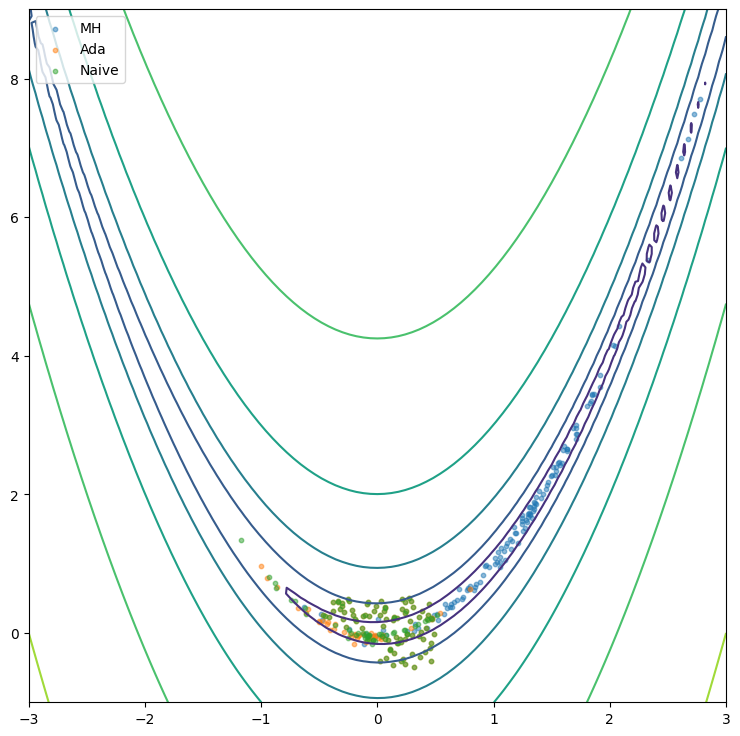

In [49]:
xs, ys = jnp.linspace(-3, 3, num=101), jnp.linspace(-1, 9, num=103)
G = jnp.stack(jnp.meshgrid(xs, ys, indexing='ij'), axis=-1)
P = log_p(G)

plt.figure(figsize=(9, 9))
plt.contour(xs, ys, jnp.log1p(-P).T)
plt.scatter(x_mh[:, 0], x_mh[:, 1], label='MH', s=10, alpha=0.5)
plt.scatter(x_ada[:, 0], x_ada[:, 1], label='Ada', s=10, alpha=0.5)
plt.scatter(x_naive[:, 0], x_naive[:, 1], label='Naive', s=10, alpha=0.5)
plt.legend(loc='upper left')
# plt.scatter(x_normal[:, 0], x_normal[:, 1], color='black')

In [24]:
x_ada

Array([[ 0.13866973,  0.3288417 ],
       [-0.06710947,  0.40316653],
       [ 0.24588609,  0.11999452],
       [-0.02665862,  0.458602  ],
       [-0.02742592,  0.50802636],
       [ 0.25762856,  0.27166283],
       [ 0.08159304,  0.3928001 ],
       [ 0.01570582, -0.36918223],
       [-0.3261727 ,  0.32832694],
       [ 0.0595448 , -0.3742484 ],
       [ 0.17386568,  0.09045053],
       [-0.33106387,  0.13055554],
       [ 0.4384266 ,  0.22724748],
       [ 0.29251456,  0.2600031 ],
       [ 0.10594082, -0.45477343],
       [-0.3607929 ,  0.1433472 ],
       [-0.3213787 ,  0.47641242],
       [ 0.14898622, -0.4343158 ],
       [-0.02903648,  0.10062255],
       [ 0.3959334 , -0.34851563],
       [ 0.31937706,  0.0831151 ],
       [ 0.4938817 ,  0.2974832 ],
       [-0.2624607 ,  0.26998472],
       [-0.26056564,  0.45936525],
       [ 0.37443984,  0.29209495],
       [-0.19284534,  0.39252818],
       [ 0.33967507,  0.2697996 ],
       [-0.13068116,  0.05863941],
       [ 0.0604279 ,